# Aufgabe 9

In [1]:
import numpy as np 
from scipy.integrate import quad
import matplotlib.pyplot as plt 
import pandas as pd
np.random.seed(42)

## a)

\begin{align*}
\Phi = \Phi_0 \cdot \left(\frac{E}{TeV}\right)^{-\gamma}
\end{align*}

Diese Funktion soll nun transformiert werden. Dafür bestimmen wir erstmal die Normierung.

\begin{align*}
A &= \int^{\infty}_{1} \Phi_0 \cdot E^{-\gamma}\; \text{d}E \\
  &= \Phi_0 \cdot \left[\frac{1}{1-\gamma} E^{-\gamma + 1} \right]_{1}^{\infty} \\
  &= \Phi_0 \cdot \frac{1}{\gamma -1} \\
\end{align*}

Nun wird die Funktion von $1$ bis $\inf$ integriert. 

\begin{align*}
A(E) &= \int^{E}_{1} \Phi_0 \cdot E^{-\gamma}\; \text{d}E \\
  &= \Phi_0 \cdot \left(- \frac{1}{\gamma -1}  \;E^{-\gamma + 1} + \frac{1}{\gamma -1}\right) \\
\end{align*}

Somit ergibt sich dann ein Gesamtergebnis von

\begin{align*}
\Phi\,(E) &= \frac{A(x)}{A} = \left(-E^{-\gamma + 1} + 1\right). \\
\end{align*}

Durch Invertieren ergibt sich dann 

\begin{align*}
E\,(\Phi) = \left(-\Phi + 1\right)^{\frac{1}{-\gamma + 1}}. \\
\end{align*}





In [2]:
def trafo(phi): #phi ist die Zufallsgröße, die Energiewerte werden zurückgegeben
    return (-phi+1)**(1/(1-2.7)) 

In [3]:
phi = np.random.uniform(0,1,10**5) #erzeugen von 10^5 Zufallszahlen zwischen 0 und 1
energie = trafo(phi) # Energiewerte

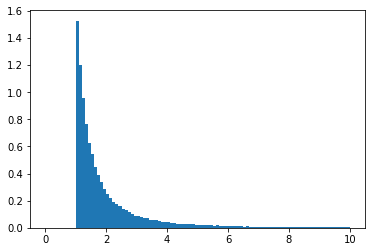

In [4]:
plt.hist(energie, bins= 100, range=[0,10], density=True)
None

In [5]:
Signal = pd.DataFrame({ 
    'Energie': energie
})

## b)

In [6]:
def p(E):
    return (1-np.exp(-E/2))**3

In [7]:
def neumann(ver_neu, energie, func):
    return (func(energie) >= ver_neu)

In [8]:
ver_neu = np.random.normal(0,1,10**5)
truefalseMaske = neumann(ver_neu, energie, p)

In [9]:
Signal["AcceptanceMask"]= pd.Series(truefalseMaske)

In [10]:
energie_neu = energie[truefalseMaske == True]

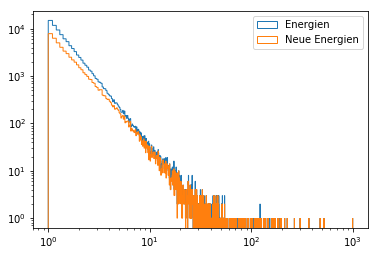

In [11]:
plt.hist(energie, bins= 10000, density=False, label="Energien", histtype="step")
plt.hist(energie_neu, bins= 10000, density=False, label="Neue Energien", histtype="step")
plt.legend(loc="best")
plt.xscale("log")
plt.yscale("log")

## c)

In [12]:
def polar():
    verteilung1, verteilung2 = np.random.uniform(0,1,1), np.random.uniform(0,1,1)
    v1, v2 = 2*verteilung1-1, 2*verteilung2-1
    s = v1**2 + v2**2 
    return np.array([s, v1, v2])

In [13]:
def polarmethode(E):
    x=[]
    i=0
    while len(x) < len(E):
        s, v1, v2 = polar()
        while (s >= 1 or s==0):
            s, v1, v2 = polar()
        x = np.append(x, np.sqrt(2*E[i]) * v1* np.sqrt(-2/s *np.log(s)) + 10*E[i])
        x = np.append(x, np.sqrt(2*E[i+1]) * v2* np.sqrt(-2/s *np.log(s)) + 10*E[i+1])
        i+=2 
    return x

In [14]:
hits = np.round(polarmethode(energie), 0) 

In [15]:
Signal["NumberOfHits"]= pd.Series(hits)

## d) 

In [16]:
def ort(numbofhits):
    sigma = 1/np.log10(numbofhits+1)
    x, y = [], []
    for i in range(len(numbofhits)):
        a, b = np.random.normal(7,sigma[i], 1), np.random.normal(3, sigma[i], 1)
        while(a<0 or a>10):
            a = np.random.normal(7,sigma[i], 1)
        while(b<0 or b>10):
            b = np.random.normal(3,sigma[i], 1)
        x = np.append(x, a)
        y = np.append(y, b)
    return [x, y]

In [17]:
x, y = ort(hits)
Signal["x"]= pd.Series(x)
Signal["y"]= pd.Series(y)
Signal.to_hdf('NeutrinoMC.hdf5', key='Signal')
Signal.head()

,Energie,AcceptanceMask,NumberOfHits,x,y
0,1.317901,False,12.0,7.639109,4.392470
1,5.874727,False,66.0,7.187508,3.541687
2,2.169629,True,21.0,6.146962,3.280138
3,1.710909,True,16.0,6.299710,1.763099
4,1.104927,False,12.0,7.362339,4.467621


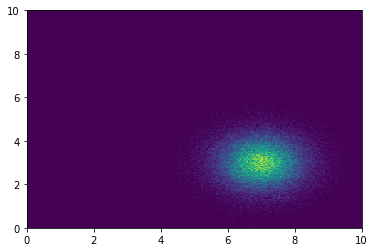

In [18]:
plt.hist2d(x, y, bins=[200, 200], range=[[0,10],[0,10]])
None

## e) 

In [19]:
#Speicher Effizient, braucht aber ewig 
def ort2(sigma, mean, rho, N):
    x = []
    y = []
    numb = N
    while len(x) < N: 
        a = np.random.normal(0,1,numb)
        b = np.random.normal(0,1,numb)
        for i in range(numb):
            a[i] = np.sqrt(1-rho**2)*sigma*a[i] + sigma*rho*b[i] + mean 
            b[i] = sigma*b[i] + mean
            if (a[i]>0 and a[i]<10 and b[i]>0 and b[i] <10):
                x = np.append(x,a[i])
                y = np.append(y,b[i])
        numb -= len(x)
    return x,y

In [20]:
#Viel zu viele werden verworfen, aber viiiel schneller
def ort3(sigma, mean, rho, N):
    a = np.random.normal(0,1,3*N)
    b = np.random.normal(0,1,3*N)
    aextra = np.sqrt(1-rho**2)*sigma*a + sigma*rho*b + mean
    bextra = sigma*b + mean
    bedingung = (aextra > 0) & (aextra < 10) & (bextra > 0) & (bextra < 10)
    x = aextra[bedingung]
    y = bextra[bedingung]
    return x[:N], y[:N]

In [21]:
hitslog = np.random.normal(2,1, 10**7)
sigma = 3
mean = 5 
rho = 0.5 
x, y = ort3(sigma, mean, rho, 10**7)

Background = pd.DataFrame({ 
    'NumberOfHits': 10**hitslog,
    'x': x,
    'y': y
})
Background.to_hdf('NeutrinoMC.hdf5', key='Background')
Background.head()

,NumberOfHits,x,y
0,3618.224653,4.454979,4.587116
1,462.891615,4.483087,6.486326
2,6.804803,7.709139,6.699728
3,153.052385,6.622578,5.371412
4,56.608049,6.354847,7.434751


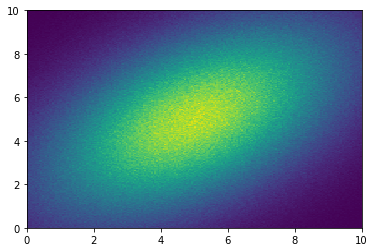

In [22]:
plt.hist2d(x, y, bins=[200, 200], range=[[0,10],[0,10]])
None

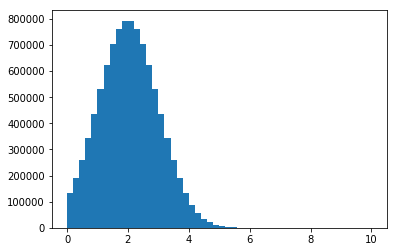

In [23]:
plt.hist(hitslog, range=(0,10), bins=50)
None

# Aufgabe 10

## Teilaufgabe a)

Der Metropolis-Hastings-Algorithmus für Zufallszahlen, die der Verteilung der Funktion $f(x)$ folgen sollen, hat die Übergangswahrscheinlichkeit 

$$ M_{i\rightarrow j} = \text{min}\left(1, \frac{f\left(x_j\right)}{f\left(x_i\right)} \frac{g\left(x_j \vert x_i\right)}{g\left(x_i \vert x_j \right)}\right)\,.$$

Dabei ist $x_i$ eine generierte Zufallszahl und $x_j$ eine vorgeschlagene Zufallszahl, die bei Annahme an die zu generierende Folge angehängt wird. Der vorgeschlagene Wert wird akzeptiert, wenn $M_{i\rightarrow j}$ größer oder gleich einer zufällig auf dem Intervall von null bis eins gewählten Zahl ist. Die Funktion $g$ ist eine Schrittvorschlags-PDF. Der Ausdruck $g\left(x_i \vert x_j \right)$ beschreibt die Übergangswahrscheinlichkeit aus dem Zustand $x_i$ in den Zustand $x_j$.

Für eine Gaußverteilung gilt 

$$g\left(x_i|x_j\right) = N \cdot \exp(-(x_i-x_j)^2)\,.$$

$\mu$ ist der Erwartungswert der Gaußverteilung. Da die Gaußverteilung symmetrisch ist, gilt dann auch

$$g\left(x_j|x_i\right) = N \cdot \exp(-(x_j-x_i)^2 = g\left(x_i|x_j\right)\,.$$

Damit wird der zweite Bruch in der Übergangswahrscheinlichkeit 1 und es bleibt für die Übergangswahrscheinlichkeit der Ausdruck 

$$ M_{i\rightarrow j} = \text{min}\left(1, \frac{f\left(x_j\right)}{f\left(x_i\right)}\right)\,.$$ 

Das entspricht genau der Übergangswahrscheinlichkeit vom Metropolis Algorithmus.


## b)

In [24]:
def metropolis(x, s, f):
    if (x[-1]-s < 0):
        xj = np.random.uniform(0, x[-1]+s, 1)
    else:
        xj = np.random.uniform(x[-1]-s, x[-1]+s, 1)
    Mij = np.min([1, f(xj)/f(x[-1])])
    eta = np.random.uniform(0, 1, 1)
    if eta <= Mij:
        c = xj
    else: 
        c = x[-1]
    return c

## c)

In [25]:
def planck(x):
    return x**3/(np.exp(x) - 1)

In [26]:
N = 1/quad(planck,0, np.inf)[0]

In [27]:
def planck_norm(x):
    return N* x**3/(np.exp(x) -1)

In [28]:
planckverteilung = np.array([30])
for i in range(10**5-1): 
    planckverteilung = np.append(planckverteilung, metropolis(planckverteilung, 2, planck_norm))

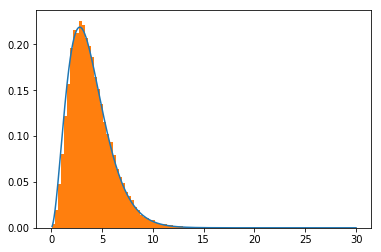

In [29]:
x = np.linspace(0.1,30, 10**5)
plt.plot(x, planck_norm(x), label="Planck Verteilung")
plt.hist(planckverteilung, bins= 100, density=True)
None

## d)

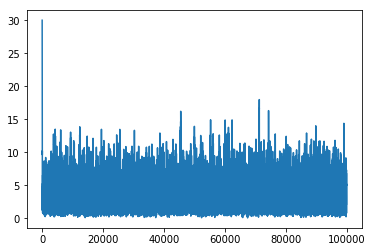

In [30]:
#Trace Plot

iteration = np.arange(10**5)
plt.plot(iteration, planckverteilung);